In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/miniconda3/envs/zoonosis/lib/python311.zip',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/lib-dynload',
 '',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [4]:
#tf_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240613/host_multi/few_shot_learning/fsl_non_idv_uniref90viridae_msl2048_transformer-l_6-h_8-d_1024-lr1e-4_classwise_auprc.csv")
# virprobert_80_20_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split70-10-20_virprobert_classwise_auprc.csv")
# virprobert_70_30_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split60-10-30_virprobert_classwise_auprc.csv")
# virprobert_50_50_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split40-10-50_virprobert_classwise_auprc.csv")
# virprobert_40_60_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split30-10-60_virprobert_classwise_auprc.csv")

                                                 

virprobert_output_auprc_file_paths =  {
    "sl256st64_w3s5": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240928/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    #"sl256st64_w5s2": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240906/host_multi/few_shot_learning/fsl_tr_w5s2q10_te_w5s2q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
}
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_non_idv_lt_1_gte_0.05_prcnt_prevalence_seq_len_in_99prcntile.csv")

In [5]:
def read_output_df(output_file_paths):
    dfs = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df["model"] = model
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n({v:.2f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [6]:
df = read_output_df(virprobert_output_auprc_file_paths)
dataset_df = pd.read_csv(dataset_file_path)

In [7]:
dataset_df.shape

(11116, 12)

In [8]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=True)
metadata_formatted

{'Cyprinus carpio': 'Cyprinus carpio\n(0.86%)',
 'Petroica australis': 'Petroica australis\n(0.85%)',
 'Felis catus': 'Felis catus\n(0.62%)',
 'Gopherus morafkai': 'Gopherus morafkai\n(0.61%)',
 'Peromyscus boylii': 'Peromyscus boylii\n(0.59%)',
 'Marmota flaviventris': 'Marmota flaviventris\n(0.57%)',
 'Bos taurus': 'Bos taurus\n(0.54%)',
 'Eptesicus fuscus': 'Eptesicus fuscus\n(0.53%)',
 'Macaca mulatta': 'Macaca mulatta\n(0.49%)',
 'Loxodonta africana': 'Loxodonta africana\n(0.45%)',
 'Mastomys natalensis': 'Mastomys natalensis\n(0.43%)',
 'Gymnorhina tibicen': 'Gymnorhina tibicen\n(0.41%)',
 'Eidolon helvum': 'Eidolon helvum\n(0.38%)',
 'Sparus aurata': 'Sparus aurata\n(0.37%)',
 'Ailurus fulgens': 'Ailurus fulgens\n(0.36%)',
 'Elephas maximus': 'Elephas maximus\n(0.36%)',
 'Oryzomys sp.': 'Oryzomys sp.\n(0.33%)',
 'Lates calcarifer': 'Lates calcarifer\n(0.33%)',
 'Bufo bufo': 'Bufo bufo\n(0.32%)',
 'Crocodylus porosus': 'Crocodylus porosus\n(0.32%)',
 'Equus caballus': 'Equus caba

In [9]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=False)
metadata_unformatted

{'Cyprinus carpio': 0.8578841647137595,
 'Petroica australis': 0.8536993639102779,
 'Felis catus': 0.6214429193170405,
 'Gopherus morafkai': 0.610980917308336,
 'Peromyscus boylii': 0.5900569132909274,
 'Marmota flaviventris': 0.5670405088717777,
 'Bos taurus': 0.5356545028456646,
 'Eptesicus fuscus': 0.5314697020421828,
 'Macaca mulatta': 0.48543689320388345,
 'Loxodonta africana': 0.4456812855708068,
 'Mastomys natalensis': 0.4331268831603616,
 'Gymnorhina tibicen': 0.4059256779377301,
 'Eidolon helvum': 0.3766320723133579,
 'Sparus aurata': 0.36826247070639434,
 'Ailurus fulgens': 0.3640776699029126,
 'Elephas maximus': 0.35989286909943086,
 'Oryzomys sp.': 0.33478406427854035,
 'Lates calcarifer': 0.33059926347505864,
 'Bufo bufo': 0.3180448610646133,
 'Crocodylus porosus': 0.31595246066287247,
 'Equus caballus': 0.305490458654168,
 'Hypsugo savii': 0.305490458654168,
 'Dipodomys merriami': 0.30339805825242716,
 'Rattus norvegicus': 0.2950284566454637,
 'Crocodilurus amazonicus': 0

In [12]:
df["prevalence"] = df["class"].apply(lambda x: metadata_unformatted[x])

In [13]:
len(metadata_formatted)

143

In [14]:
classes = list(metadata_unformatted.keys())
classes

['Cyprinus carpio',
 'Petroica australis',
 'Felis catus',
 'Gopherus morafkai',
 'Peromyscus boylii',
 'Marmota flaviventris',
 'Bos taurus',
 'Eptesicus fuscus',
 'Macaca mulatta',
 'Loxodonta africana',
 'Mastomys natalensis',
 'Gymnorhina tibicen',
 'Eidolon helvum',
 'Sparus aurata',
 'Ailurus fulgens',
 'Elephas maximus',
 'Oryzomys sp.',
 'Lates calcarifer',
 'Bufo bufo',
 'Crocodylus porosus',
 'Equus caballus',
 'Hypsugo savii',
 'Dipodomys merriami',
 'Rattus norvegicus',
 'Crocodilurus amazonicus',
 'Tarsiger cyanurus',
 'Chelonia mydas',
 'Mus musculus',
 'Tursiops aduncus',
 'Tadarida brasiliensis',
 'Ovis aries',
 'Rhinolophus ferrumequinum',
 'Pteropus scapulatus',
 'Heloderma suspectum',
 'Anas superciliosa',
 'Squalius cephalus',
 'Oryctolagus cuniculus',
 'Coendou prehensilis',
 'Anas castanea',
 'Grus japonensis',
 'Amazona oratrix',
 'Callorhinus ursinus',
 'Phylloscopus inornatus',
 'Macaca fuscata',
 'Hoplobatrachus rugulosus',
 'Phrynocephalus erythrurus',
 'Pero

In [15]:
classes_order = {k:i for i, k in enumerate(classes)}
classes_order

{'Cyprinus carpio': 0,
 'Petroica australis': 1,
 'Felis catus': 2,
 'Gopherus morafkai': 3,
 'Peromyscus boylii': 4,
 'Marmota flaviventris': 5,
 'Bos taurus': 6,
 'Eptesicus fuscus': 7,
 'Macaca mulatta': 8,
 'Loxodonta africana': 9,
 'Mastomys natalensis': 10,
 'Gymnorhina tibicen': 11,
 'Eidolon helvum': 12,
 'Sparus aurata': 13,
 'Ailurus fulgens': 14,
 'Elephas maximus': 15,
 'Oryzomys sp.': 16,
 'Lates calcarifer': 17,
 'Bufo bufo': 18,
 'Crocodylus porosus': 19,
 'Equus caballus': 20,
 'Hypsugo savii': 21,
 'Dipodomys merriami': 22,
 'Rattus norvegicus': 23,
 'Crocodilurus amazonicus': 24,
 'Tarsiger cyanurus': 25,
 'Chelonia mydas': 26,
 'Mus musculus': 27,
 'Tursiops aduncus': 28,
 'Tadarida brasiliensis': 29,
 'Ovis aries': 30,
 'Rhinolophus ferrumequinum': 31,
 'Pteropus scapulatus': 32,
 'Heloderma suspectum': 33,
 'Anas superciliosa': 34,
 'Squalius cephalus': 35,
 'Oryctolagus cuniculus': 36,
 'Coendou prehensilis': 37,
 'Anas castanea': 38,
 'Grus japonensis': 39,
 'Ama

In [16]:
len(classes)

143

In [17]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 640x480 with 0 Axes>

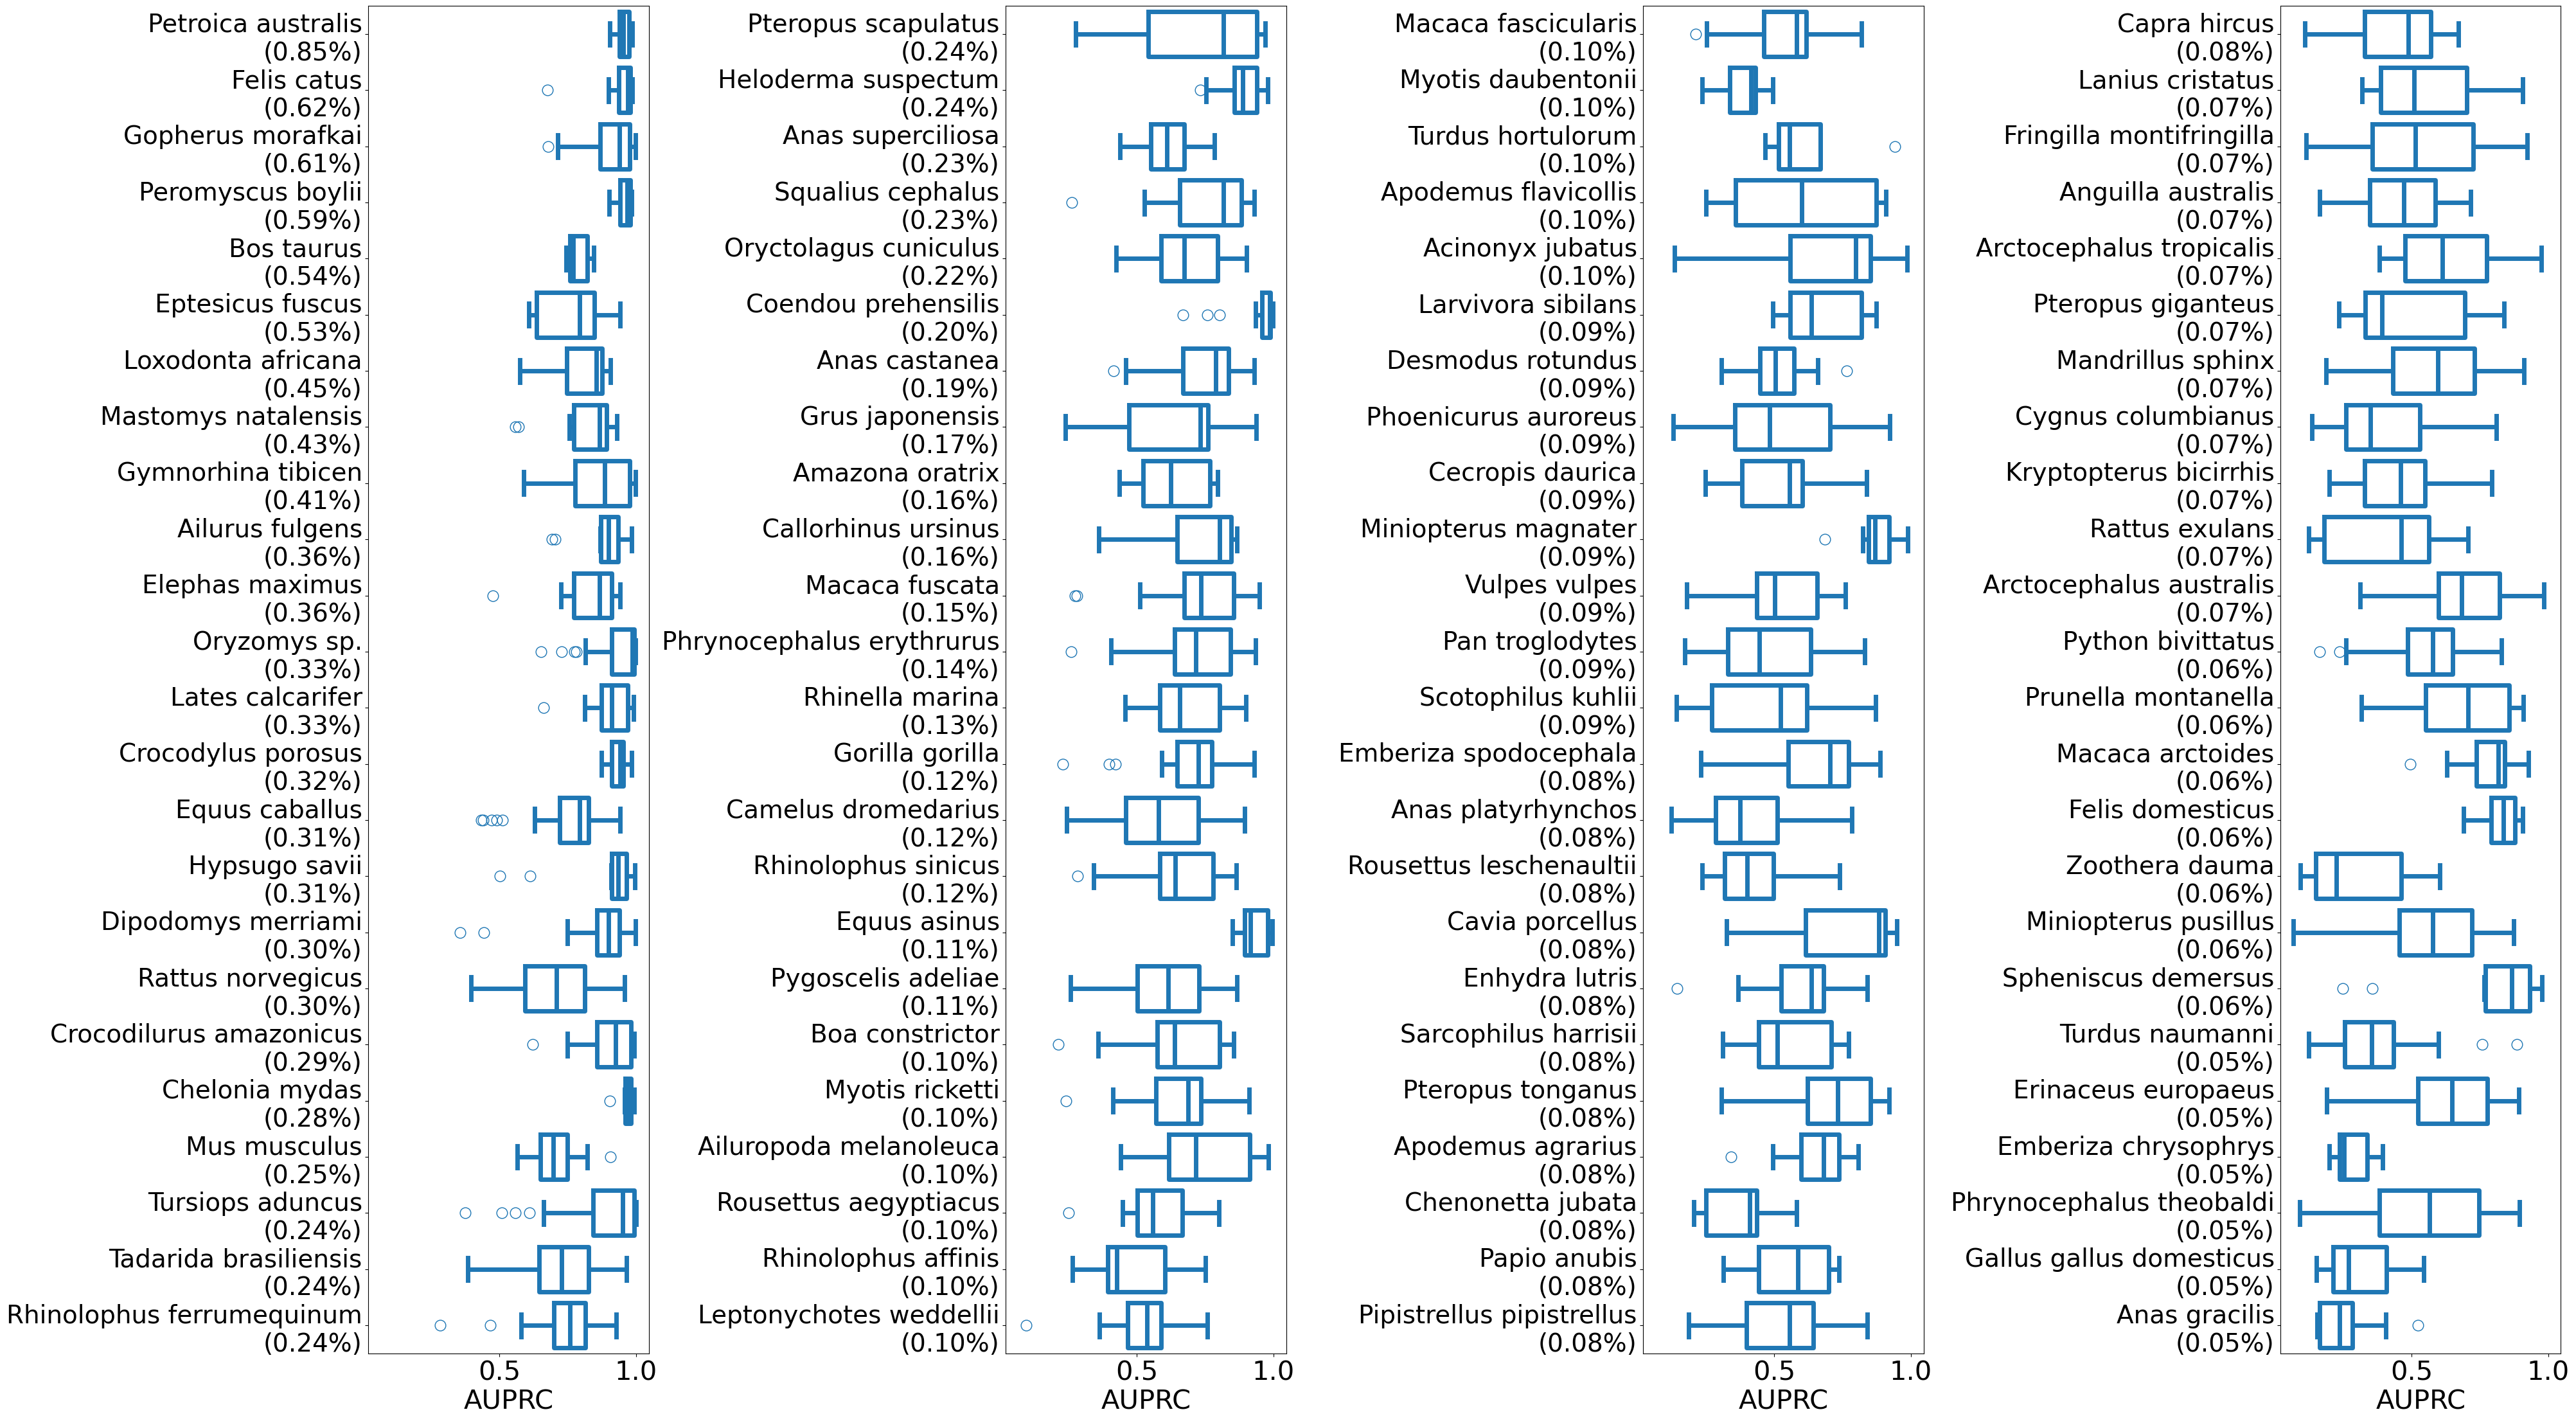

In [29]:
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15

plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 4, figsize=(40, 22), sharex=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 28
#plt.rcParams.update({'font.size': 30})

df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 4)
for i in range(4):
    #sns.violinplot(data=df[df["class"].isin(bins[i])],  x="auprc", y="class", hue="model", ax=axs[i], split=True, orient="h", linewidth=2.5, fill=False,  order=bins[i])
    sns.boxplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs[i], orient="h", linewidth=5, fill=False, fliersize=12, order=bins[i])
    
    #sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", order=bins[i])
    #plt.draw()

    axs[i].set_ylabel("")
    axs[i].set_xlabel("AUPRC", fontsize="30")

plt.tight_layout(pad=.1)
#plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_lt1_gte0.05_prcnt_classwise_boxplot.pdf"))
plt.show()

In [17]:
min_prevalence = df["prevalence"].min()
print(f"min prevalence = {min_prevalence}")
min_prevalence_df = df[df["prevalence"] == min_prevalence]
min_prevalence_df[["class", "auprc"]].groupby("class").agg(["min", "max", "mean", "median"])

min prevalence = 0.05021760964178105


auprc                              
                          min       max      mean    median
class                                                      
Anas gracilis        0.152485  0.523023  0.256761  0.235075
Eptesicus serotinus  0.081264  0.867060  0.423594  0.438817
Salmo salar          0.188875  0.932663  0.552773  0.511312
Tursiops truncatus   0.123463  0.747728  0.411991  0.465829

In [18]:
dataset_df["virus_host_name"].value_counts()["Salmo salar"]

24

In [19]:
max_prevalence = df["prevalence"].max()
print(f"max prevalence = {max_prevalence}")
max_prevalence_df = df[df["prevalence"] == max_prevalence]
max_prevalence_df[["class", "auprc"]].groupby("class").agg(["min", "max", "mean", "median"])

max prevalence = 0.8536993639102779


auprc                              
                         min       max      mean    median
class                                                     
Petroica australis  0.902619  0.985065  0.952442  0.953495

In [20]:
dataset_df["virus_host_name"].value_counts()["Petroica australis"]

408

In [21]:
mean_auprc_df = df[["model", "class", "auprc"]].groupby(["model", "class"]).agg("mean").reset_index()
mean_auprc_df["prevalence"] = mean_auprc_df["class"].apply(lambda x: metadata_unformatted[x])
mean_auprc_df

,model,class,auprc,prevalence
0,sl256st64_w3s5,Acinonyx jubatus,0.687577,0.096250
1,sl256st64_w3s5,Ailuropoda melanoleuca,0.744852,0.104620
2,sl256st64_w3s5,Ailurus fulgens,0.877106,0.364078
3,sl256st64_w3s5,Amazona oratrix,0.625156,0.163207
4,sl256st64_w3s5,Anas castanea,0.736546,0.190408
...,...,...,...,...
94,sl256st64_w3s5,Turdus naumanni,0.383094,0.054402
95,sl256st64_w3s5,Tursiops aduncus,0.873234,0.240626
96,sl256st64_w3s5,Tursiops truncatus,0.411991,0.050218
97,sl256st64_w3s5,Vulpes vulpes,0.515944,0.087881


In [22]:
print(f"Lowest mean AUPRC = {mean_auprc_df['auprc'].min()}")
print(f"Maximum mean AUPRC = {mean_auprc_df['auprc'].max()}")

Lowest mean AUPRC = 0.2567609650068991
Maximum mean AUPRC = 0.9636952648377559


In [30]:
median_auprc_df = df[["model", "class", "auprc"]].groupby(["model", "class"]).agg("median").reset_index()
median_auprc_df["prevalence"] = median_auprc_df["class"].apply(lambda x: metadata_unformatted[x])
median_auprc_df

,model,class,auprc,prevalence
0,sl256st64_w3s5,Acinonyx jubatus,0.797278,0.096250
1,sl256st64_w3s5,Ailuropoda melanoleuca,0.714786,0.104620
2,sl256st64_w3s5,Ailurus fulgens,0.899991,0.364078
3,sl256st64_w3s5,Amazona oratrix,0.622922,0.163207
4,sl256st64_w3s5,Anas castanea,0.788884,0.190408
...,...,...,...,...
94,sl256st64_w3s5,Turdus naumanni,0.354023,0.054402
95,sl256st64_w3s5,Tursiops aduncus,0.949661,0.240626
96,sl256st64_w3s5,Tursiops truncatus,0.465829,0.050218
97,sl256st64_w3s5,Vulpes vulpes,0.500855,0.087881


In [31]:
print(f"Lowest median AUPRC = {median_auprc_df['auprc'].min()}")
print(f"Maximum median AUPRC = {median_auprc_df['auprc'].max()}")

Lowest median AUPRC = 0.2252251817262319
Maximum median AUPRC = 0.9866364723970629


In [25]:
median_prevalence = np.median(np.array(list(metadata_unformatted.values())))
print(f"Median class prevalence = {median_prevalence}")
print(f"Median number of samples = {median_prevalence * 47792/100}")

mean_prevalence = np.mean(np.array(list(metadata_unformatted.values())))
print(f"Mean class prevalence = {mean_prevalence}")
print(f"Mean number of samples = {mean_prevalence * 47792/100}")

Median class prevalence = 0.09415801807833947
Median number of samples = 45.0
Mean class prevalence = 0.16265120885140974
Mean number of samples = 77.73426573426575


In [26]:
print(f"Median auprc = {df['auprc'].median()}")
print(f"Mean auprc = {df['auprc'].mean()}")

Median auprc = 0.6779599337916302
Mean auprc = 0.6504887798769229


<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

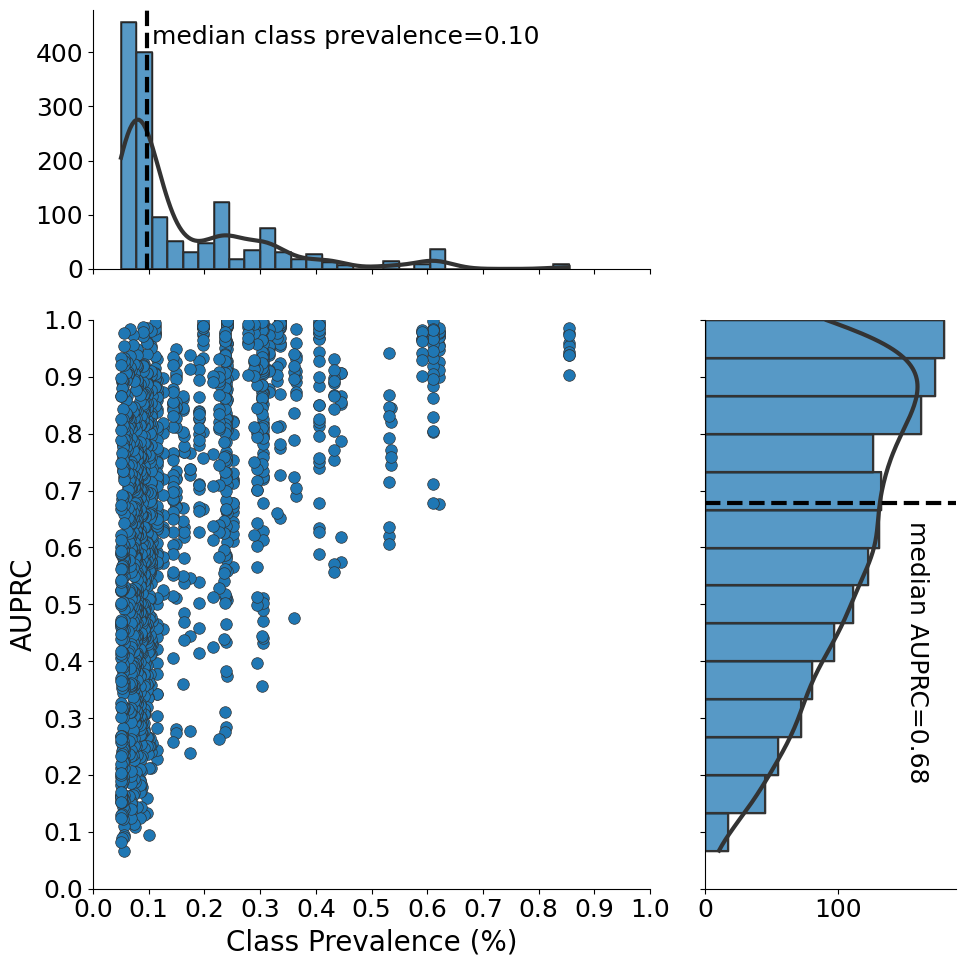

In [87]:
plt.clf()
plt.figure(figsize=(8,8))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18



ax = sns.jointplot(data=df, x="prevalence", y="auprc",
                   height=10, ylim=(0, 1),  xlim=(0, 1),
                   ratio=2, marginal_ticks=True, legend=True)
ax.plot_joint(sns.scatterplot, alpha=1, s=70, edgecolor=".2", linewidth=.5)
ax.plot_marginals(sns.histplot, kde=True, fill=False, color="0.2", line_kws={"color": "black", "lw": 3, "ls": "-"})
#ax = sns.scatterplot(mean_auprc_df, x="prevalance", y="auprc", hue="model", alpha=1)

# ax = sns.JointGrid()
# x, y = penguins["bill_length_mm"], penguins["bill_depth_mm"]
# sns.scatterplot(data=df, x="prevalence", y="auprc", ec="b", fc="none", s=100, linewidth=1.5, ax=g.ax_joint)
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
# sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)


ax.ax_joint.set_xlabel("Class Prevalence (%)", fontsize=20)
ax.ax_joint.set_ylabel("AUPRC", fontsize=20)
ax.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.ax_joint.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.ax_joint.yaxis.set_major_formatter(ticker.ScalarFormatter())

ax.ax_marg_x.set_ylabel("Class Prevalence (%)")
ax.ax_marg_y.set_ylabel("ABCD")


ax.ax_marg_x.axvline(df["prevalence"].median(), color='k', ls='--', lw=3)
ax.ax_marg_y.axhline(df["auprc"].median(), color='k', ls='--', lw=3)

ax.ax_marg_x.annotate(f"median class prevalence={'{0:.2f}'.format(df['prevalence'].median())}", xy=(df["prevalence"].median(), 450), xycoords="data",
            xytext=(df["prevalence"].median() + .01, 450), textcoords='data',
            va='top', ha='left')

ax.ax_marg_y.annotate(f"median AUPRC={'{0:.2f}'.format(df['auprc'].median())}", xy=(102, df["auprc"].median()), xycoords="data",
            xytext=(150, df["prevalence"].median()+.55), textcoords='data',
            va='top', ha='left', rotation=-90)

ax = plt.gca()
ax.figure.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_lt1_gte0.05_prcnt_auprc_scatterplot_w_hist.pdf"))
plt.show()